First we preprocess the data. Replace the string in original data with integer to make it easy for us to process.

In [8]:
from tkinter.messagebox import RETRY
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS
pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")
relative_path = ".."

def get_dataset():
    data = pd.read_csv(relative_path + "/data/income_data/train.csv")
    data = data.dropna(axis=0)
    data.rename(columns={'educational-num': 'educational_num', "income_>50K": "income_bigger_than_50K",
                         'marital-status': 'marital_status', 'native-country': 'native_country'}, inplace=True)
    data["race"] = data["race"].replace(to_replace="Amer-Indian-Eskimo",
                                        value="Indian")
    data["race"] = data["race"].replace(to_replace="Asian-Pac-Islander",
                                        value="Asian")

    occupationDict = {
        "Exec-managerial": 0,
        "Other-service": 4,
        "Transport-moving": 5,
        "Adm-clerical": 6,
        "Machine-op-inspct": 5,
        "Sales": 3,
        "Handlers-cleaners": 5,
        "Farming-fishing": 5,
        "Protective-serv": 2,
        "Prof-specialty": 2,
        "Craft-repair": 1,
        "Tech-support": 5,
        "Priv-house-serv": 5,
        "Armed-Forces": 5
    }
    data["occupation"] = data["occupation"].map(occupationDict)
    raceDict = {
        "White": 0,
        "Black": 1,
        "Asian": 2,
        "Indian": 2,
        "Other": 2
    }
    data["race"] = data["race"].map(raceDict)
    genderDict = {
        "Male": 0,
        "Female": 1
    }
    data["gender"] = data["gender"].map(genderDict)
    maritalDict = {
        "Divorced": 2,
        "Never-married": 1,
        "Married-civ-spouse": 0,
        "Widowed": 2,
        "Separated": 2,
        "Married-spouse-absent": 2,
        "Married-AF-spouse": 2
    }
    data["marital_status"] = data["marital_status"].map(maritalDict)
    def map_country(native_country):
        if native_country == "United-States":
            return 0
        else:
            return 1
    data["native_country"] = data["native_country"].map(map_country)
    workclassDict = {
        'Private': 0,
        'State-gov': 1,
        'Self-emp-not-inc': 2,
        'Federal-gov': 1,
        'Local-gov': 1,
        'Self-emp-inc': 1,
        'Without-pay': 1
    }
    data["workclass"] = data["workclass"].map(workclassDict)
    educationDict = {
        'Doctorate': 1,
        '12th': 0,
        'Bachelors': 1,
        '7th-8th': 0,
        'Some-college': 1,
        'HS-grad': 0,
        '9th': 0,
        '10th': 0,
        '11th': 0,
        'Masters': 1,
        'Preschool': 0,
        '5th-6th': 0,
        'Prof-school': 0,
        'Assoc-voc': 0,
        'Assoc-acdm': 0,
        '1st-4th': 0
    }
    data["education"] = data["education"].map(educationDict)
    def map_relationship(relationship):
        if relationship == "Husband":
            return 0
        if relationship == "Not-in-family":
            return 1
        else:
            return 2
    data["relationship"] = data["relationship"].map(map_relationship)
    data.to_csv(relative_path + "/data/income_data/modified_train.csv")
    return data
print(get_dataset())

       age  workclass  ...  native_country  income_bigger_than_50K
0       67          0  ...               0                       1
1       17          0  ...               0                       0
2       31          0  ...               0                       1
3       58          1  ...               0                       0
4       25          1  ...               0                       0
...    ...        ...  ...             ...                     ...
43952   52          0  ...               0                       1
43953   19          0  ...               0                       0
43954   30          0  ...               0                       0
43955   46          0  ...               0                       0
43956   30          0  ...               0                       0

[40727 rows x 15 columns]


Modify the data set

In [3]:
from torch.utils.data import Dataset

class imcomedataset(Dataset):

  def __init__(self,train_data,train_outcome,prob):

    self.x_train = torch.tensor(train_data, dtype=torch.float32)
    self.y_train = torch.tensor(train_outcome, dtype=torch.float32)
    self.prob = torch.from_numpy(prob.to_numpy())

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx],self.prob[idx]

Then we modify the training model.

In [5]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Module

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 10)
        self.hidden_fc = nn.Linear(10, 10)
        self.output_fc = nn.Linear(10, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]

        h3 = self.output_fc(h_2)
        # y_pred = [batch size, output dim]


        y_pred = F.sigmoid(h3)
        #y_pred = F.softmax(h3, dim=1)
        return y_pred, h3

Modify the Loss

In [6]:
from torch.nn import Module

class CustomLoss(Module):
    def __init__(self):
        super().__init__()

    def forward(self, predict_y, y,p):

        temp = y - torch.mul(predict_y, p)

        return torch.mean(torch.square(temp))

First Stage

In [7]:
from sklearn.linear_model import LogisticRegression
from data_processor import get_xp
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# this function will sample based on the probility and times give.
# the return is a list of samples
def repeat_sample(times=1, possiblity=0.5):
    temp = []

    def sample(num):
        u = np.random.rand()

        return 1 if u < num else 0

    for i in range(times):
        a = sample(possiblity)
        temp.append(a)

    return temp


# this function will build the new treatments
def build(x, probilities, times=1, save=False):
    treatments = [repeat_sample(times, i) for i in probilities]
    data = np.hstack((x.to_numpy(), treatments))
    new = pd.DataFrame(data, columns=list(x.columns)
                                     + ["p" + str(i) for i in range(0, times)])

    if save:
        new.to_csv("../data/income_data/new X.csv")
        print("Successful saved!")

    return new


# this function will do the first stage and return a new x.
# ml method will have 4 opinions
# save will auto save the new x with sample result to a csv file.
def solve_stage_one(ml_method="LR", save=False):
    x, y = get_xp()

    d = {
        "LR": LogisticRegression(),
        "ADA": AdaBoostClassifier(),
        "FOREST": RandomForestClassifier(),
        "MLP": MLPClassifier(),
    }

    model = d[ml_method.upper()]
    clf = model.fit(x, y)
    pred = clf.predict(x)
    probilities = clf.predict_proba(x)[:, 1]
    print(classification_report(y, pred))

    new_x = build(x, probilities, 1000, save)

    return new_x

print(solve_stage_one("FOREST", save=True))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     22252
           1       0.86      0.83      0.85     18475

    accuracy                           0.86     40727
   macro avg       0.86      0.86      0.86     40727
weighted avg       0.86      0.86      0.86     40727

Successful saved!
       workclass  age  ...  p998  p999
0              0   67  ...     1     1
1              0   17  ...     0     0
2              0   31  ...     0     0
3              1   58  ...     0     0
4              1   25  ...     1     0
...          ...  ...  ...   ...   ...
40722          0   52  ...     1     1
40723          0   19  ...     1     0
40724          0   30  ...     1     1
40725          0   46  ...     0     0
40726          0   30  ...     0     0

[40727 rows x 1009 columns]


Second Stage

Epoch: 01 | Epoch Time: 0m 4s
Train Loss: 0.179 | Train Acc: 75.44%
Epoch: 02 | Epoch Time: 0m 3s
Train Loss: 0.172 | Train Acc: 76.88%
Epoch: 03 | Epoch Time: 0m 3s
Train Loss: 0.171 | Train Acc: 76.73%
Epoch: 04 | Epoch Time: 0m 4s
Train Loss: 0.171 | Train Acc: 75.57%
Epoch: 05 | Epoch Time: 0m 3s
Train Loss: 0.171 | Train Acc: 74.98%
Epoch: 06 | Epoch Time: 0m 3s
Train Loss: 0.170 | Train Acc: 73.40%
Epoch: 07 | Epoch Time: 0m 3s
Train Loss: 0.168 | Train Acc: 76.58%
Epoch: 08 | Epoch Time: 0m 4s
Train Loss: 0.167 | Train Acc: 74.09%
Epoch: 09 | Epoch Time: 0m 4s
Train Loss: 0.168 | Train Acc: 74.50%
Epoch: 10 | Epoch Time: 0m 3s
Train Loss: 0.167 | Train Acc: 76.87%
Epoch: 11 | Epoch Time: 0m 3s
Train Loss: 0.167 | Train Acc: 75.01%
Epoch: 12 | Epoch Time: 0m 3s
Train Loss: 0.167 | Train Acc: 77.53%
Epoch: 13 | Epoch Time: 0m 4s
Train Loss: 0.167 | Train Acc: 72.53%
Epoch: 14 | Epoch Time: 0m 4s
Train Loss: 0.167 | Train Acc: 74.32%
Epoch: 15 | Epoch Time: 0m 3s
Train Loss: 0.167 

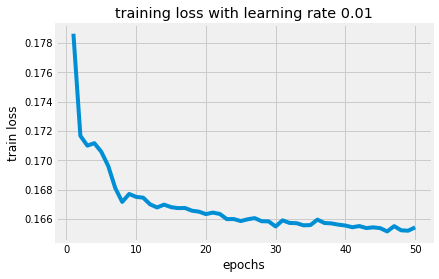

              precision    recall  f1-score   support

         0.0       0.89      0.78      0.83     61270
         1.0       0.52      0.71      0.60     20184

    accuracy                           0.77     81454
   macro avg       0.71      0.75      0.72     81454
weighted avg       0.80      0.77      0.78     81454

roc_auc_score:0.7480828580422282
train_accuracy_score:0.7663834802465195
---------------------------------------------------------------------------------------------------
ATE = 0.14368846219952366


In [9]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

from data_processor import solve_sample



class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 10)
        self.hidden_fc = nn.Linear(10, 10)
        self.output_fc = nn.Linear(10, output_dim)

    def forward(self, x):
        # x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]
        h3 = self.output_fc(h_2)
        # y_pred = [batch size, output dim]
        y_pred = F.sigmoid(h3)
        #y_pred = F.softmax(h3, dim=1)
        return y_pred


    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def calculate_accuracy(self, y_pred, y):
        # y_pred = y_pred.detach().numpy().flatten()
        # y_fact = pd.read_csv('../data/income_data/modified_train.csv')[['education', 'income_bigger_than_50K']]
        # correct = 0
        # for i in range(len(y_pred)):
        #     if y_pred[i] >= 0.5:
        #         y_pred[i] = 1.0
        #     else:
        #         y_pred[i] = 0.0
        # for i in range(len(y_fact)):
        #     if y_fact["education"][i] == 1:
        #         correct += (float(y_fact["income_bigger_than_50K"][i]) == y_pred[2 * i])
        #     else:
        #         correct += (float(y_fact["income_bigger_than_50K"][i]) == y_pred[2 * i + 1])
        # acc = float(correct) / float(len(y_fact))
        top_pred = (y_pred>0.5).float()
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
        return acc

    def evaluate_prediction(self, y_pred, y):
        y_pred = y_pred.detach().numpy().flatten()
        y = y.detach().numpy().flatten()
        for i in range(len(y_pred)):
            if y_pred[i] >= 0.5:
                y_pred[i] = 1.0
            else:
                y_pred[i] = 0.0
        return classification_report(y, y_pred), roc_auc_score(y, y_pred), accuracy_score(y, y_pred)


    def plot_train_loss(self, EPOCHS, history_train_loss, lr):
        plt.figure()
        plt.plot([i+1 for i in range(EPOCHS)], history_train_loss)
        plt.xlabel('epochs')
        plt.ylabel('train loss')
        plt.title('training loss with learning rate '+str(lr))
        # plt.legend()
        plt.show()

  
    def fit(self, x, y, prob, EPOCHS=50, lr=0.01, batch_size = 256):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        num_sample = len(x)
        total_batch = num_sample // batch_size
        
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        prob = torch.tensor(prob, dtype=torch.float32)

        history = []
        for epoch in range(EPOCHS):
            start_time = time.monotonic()

            all_idx = np.arange(num_sample)
            np.random.shuffle(all_idx)
            
            epoch_loss = 0

            # Mini-batch Training
            for batch_num in range(total_batch):
                selected_idx = all_idx[batch_size*batch_num:(batch_num+1)*batch_size]
                sub_x = x[selected_idx]
                sub_y = y[selected_idx]
                sub_prob = prob[selected_idx]

                optimizer.zero_grad()
                pred_y = self.forward(sub_x)
                
                xent_loss = 0
                for i in range(len(selected_idx)):
                    xent_loss += (sub_y[i] - sub_prob[i] * pred_y[i])**2
                          
                loss = xent_loss
                loss.backward()
                optimizer.step()
                epoch_loss += xent_loss

            pred_y_eval = model.forward(x)

            train_loss = epoch_loss.item() / num_sample
            history.append(train_loss)
            train_acc = self.calculate_accuracy(pred_y_eval, y)
            end_time = time.monotonic()
            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

            # Plot train loss & Print report after the last epoch
            if epoch == EPOCHS-1:
                self.plot_train_loss(EPOCHS, history, lr)
                train_report, train_roc_auc_score, train_accuracy_score = self.evaluate_prediction(pred_y_eval, y)
                print(train_report)
                print("roc_auc_score:" + str(train_roc_auc_score))
                print("train_accuracy_score:" + str(train_accuracy_score))
                print("---------------------------------------------------------------------------------------------------")




    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred_y = self.forward(x)
        pred_y = (pred_y>0.5).float().detach()
        pred_y = torch.flatten(pred_y).numpy()
        return pred_y
        



# Stage 1 to Stage 2
xp, probability = solve_sample()
# Input value of the outcome network
x = xp[["workclass", "marital_status", "occupation", "relationship", "gender", 
        "native_country", "age", "education"]].to_numpy()
# Groudtruth value of the outcome network
y = xp[[">=50K"]].to_numpy()
# Probability
probability = probability.to_numpy()


# Initialize input & output dimensions
input_dim = x.shape[1]
output_dim = 1


###
model = MLP(input_dim, output_dim)
model.fit(x, y, probability)



# Counterfactual Prediction & Calculate ATE

def calculate_ate(y_pred, y_fact):
    ate = 0
    size = len(y_fact)
    for i in range(size):
        if y_fact['education'][i] == 1:
            ite = y_fact['income_bigger_than_50K'][i] - y_pred[2*i+1]
        else:
            ite = y_pred[2*i] - y_fact['income_bigger_than_50K'][i]
        ate += ite
    ate = ate / size
    return ate

y_pred = model.predict(x)
y_fact = pd.read_csv('../data/income_data/modified_train.csv')[['education','income_bigger_than_50K']]

print('ATE = '+ str(calculate_ate(y_pred, y_fact)))
